In [4]:
from transformers import AutoModelForCausalLM
import torch
from cvx_proj.quantization.lattice import LatticeQuantizer
from cvx_proj.quantization.rtn import RTNQuantizer
from cvx_proj.algo.alt_min import AlternatingMinimization
from cvx_proj.algo.admm import ADMM
from cvx_proj.algo.pgd import PGD, PGDRelaxed
from cvx_proj.algo.douglas_rachford import DouglasRachford
import matplotlib.pyplot as plt
import nibabel as nib
from torcheval.metrics import PeakSignalNoiseRatio

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
torch.set_grad_enabled(False)

In [7]:
# The following is from https://github.com/Cornell-RelaxML/quip-sharp
def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H

In [8]:
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf", torch_dtype="auto", low_cpu_mem_usage=True
).cpu()

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s]


In [9]:
LAYER_IDX = 10
HESSIAN_KEY = "qkv"
DEVICE = "cuda:0"

In [10]:
W = model.model.layers[LAYER_IDX].self_attn.q_proj.weight.float().to(DEVICE)
# W /= W.square().mean().sqrt().item()

H_data = torch.load(f"../hessians/{LAYER_IDX}_{HESSIAN_KEY}.pt", map_location=DEVICE)
H = flat_to_sym(H_data['flatH'], H_data['n'])

# Add back in the mean
mu = H_data['mu']
H.add_(mu[None, :] * mu[:, None])
H.div_(torch.diag(H).mean())
H = regularize_H(H, H_data['n'], 1e-2)

In [11]:
Q_quant = LatticeQuantizer(num_bits=2)
LR_quant = LatticeQuantizer(num_bits=4)
RANK = 128

In [79]:
admm_rho = 0.9
pgd_eta = 1e-4
relaxed_pgd_eta = 1e-1
pgd_lambda = 1e-3

In [82]:
decomps = {
    "Douglas-Rachford": (DouglasRachford, {}),
    f"ADMM (rho={admm_rho})": (ADMM, {"rho": admm_rho}),
    f"PGD (Relaxed, eta=1e-1, lambda=1e-3)": (PGDRelaxed, {"eta": relaxed_pgd_eta, "lmbda": pgd_lambda}),
    "Alt Min": (AlternatingMinimization, {})
}

In [83]:
errors = {}
for name, (decomp_cls, kwargs) in decomps.items():
    decomp = decomp_cls(rank=128, data_aware=False, quant_Q=Q_quant, quant_LR=LR_quant)
    decomp.decompose(W, H, n_iter=100, n_iter_inner=5, **kwargs)
    errors[name] = decomp.errors

100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


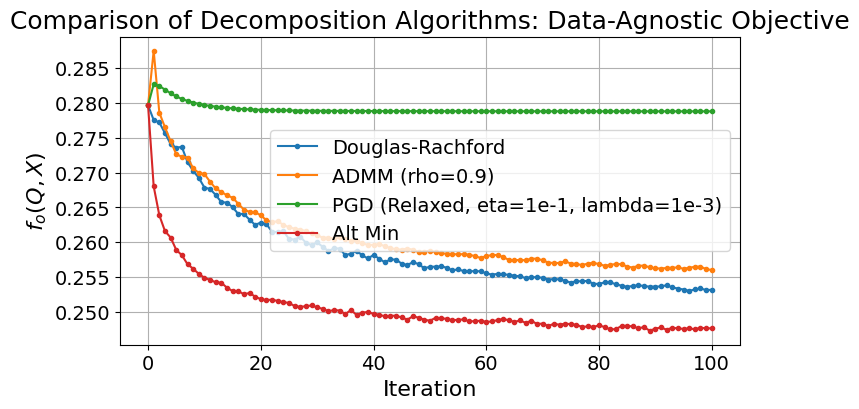

In [84]:
plt.figure(figsize=(8, 4))
plt.title("Comparison of Decomposition Algorithms: Data-Agnostic Objective", fontdict={'size': 18})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Iteration", fontdict={'size': 16})
plt.ylabel("$f_o(Q, X)$", fontdict={'size': 16})

for name, error_list in errors.items():
    plt.plot(error_list, '.-', label=name)
plt.legend(fontsize=14)
plt.grid(axis="both")
plt.savefig("dr_data_agnostic.png", bbox_inches='tight')

In [86]:
admm_rho = 0.55
pgd_eta = 1e-4
relaxed_pgd_eta = 1e-4
pgd_lambda = 1e-3

In [88]:
decomps = {
    "Douglas-Rachford": (DouglasRachford, {}),
    f"ADMM (rho={admm_rho})": (ADMM, {"rho": admm_rho}),
    f"PGD (Relaxed, eta={relaxed_pgd_eta}, lambda={pgd_lambda})": (PGDRelaxed, {"eta": relaxed_pgd_eta, "lmbda": pgd_lambda}),
    "Alt Min": (AlternatingMinimization, {})
}

In [23]:
errors_2 = {}
for name, (decomp_cls, kwargs) in decomps.items():
    decomp = decomp_cls(rank=128, data_aware=True, quant_Q=Q_quant, quant_LR=LR_quant)
    decomp.decompose(W, H, n_iter=100, n_iter_inner=5, **kwargs)
    errors_2[name] = decomp.errors

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


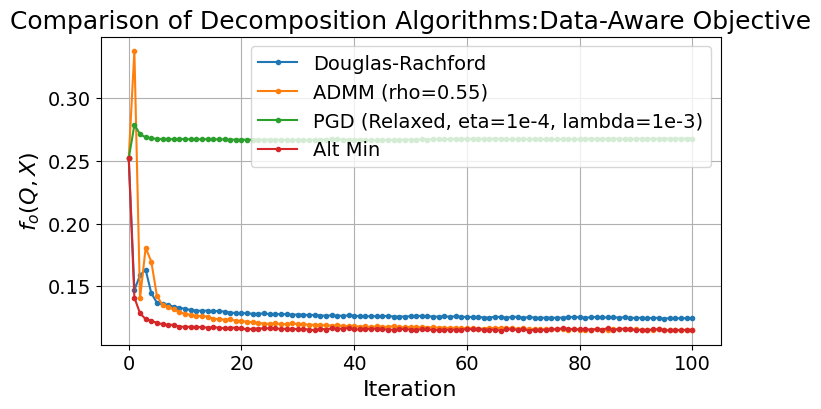

In [105]:
plt.figure(figsize=(8, 4))
plt.title("Comparison of Decomposition Algorithms:Data-Aware Objective", fontdict={'size': 18})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Iteration", fontdict={'size': 16})
plt.ylabel("$f_o(Q, X)$", fontdict={'size': 16})

for name, error_list in errors_2.items():
    plt.plot(error_list, '.-', label=name)
plt.legend(fontsize=14)
plt.grid(axis="both")
plt.savefig("dr_data_agnostic.png", bbox_inches='tight')

In [475]:
pgd = PGD(rank=128, data_aware=False, quant_Q=Q_quant, quant_LR=LR_quant)
pgd.decompose(W, H, n_iter=100, eta=1e-5, n_iter_inner=5)

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


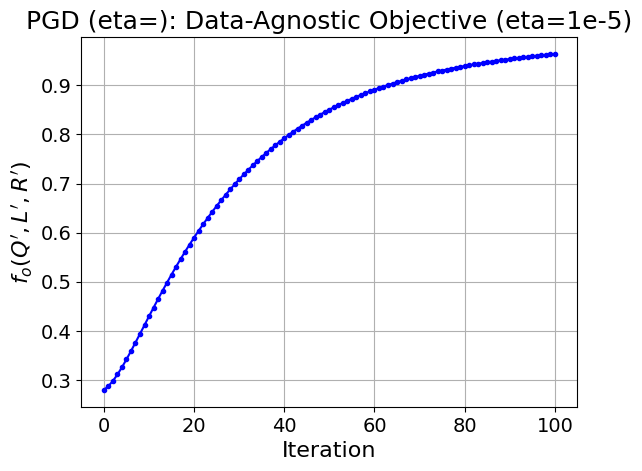

In [477]:
plt.title("PGD (eta=): Data-Agnostic Objective (eta=1e-5)", fontdict={'size': 18})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Iteration", fontdict={'size': 16})
plt.ylabel("$f_o(Q', L', R')$", fontdict={'size': 16})
plt.plot(pgd.errors, 'b.-')
plt.grid(axis="both")

In [478]:
pgd2 = PGD(rank=128, data_aware=True, quant_Q=Q_quant, quant_LR=LR_quant)
pgd2.decompose(W, H, n_iter=100, eta=1e-5, n_iter_inner=5)

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


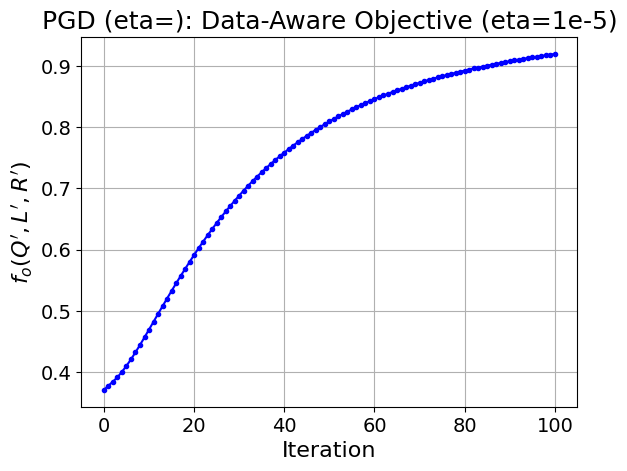

In [479]:
plt.title("PGD (eta=): Data-Aware Objective (eta=1e-5)", fontdict={'size': 18})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Iteration", fontdict={'size': 16})
plt.ylabel("$f_o(Q', L', R')$", fontdict={'size': 16})
plt.plot(pgd2.errors, 'b.-')
plt.grid(axis="both")

In [25]:
LAYER_IDX = 10
HESSIAN_KEY = "o"
DEVICE = "cuda:0"

In [26]:
W = model.model.layers[LAYER_IDX].self_attn.o_proj.weight.float().to(DEVICE)
# W /= W.square().mean().sqrt().item()

H_data = torch.load(f"../hessians/{LAYER_IDX}_{HESSIAN_KEY}.pt", map_location=DEVICE)
H = flat_to_sym(H_data['flatH'], H_data['n'])

# Add back in the mean
mu = H_data['mu']
H.add_(mu[None, :] * mu[:, None])
H.div_(torch.diag(H).mean())
H = regularize_H(H, H_data['n'], 1e-2)

In [27]:
Q_quant = LatticeQuantizer(num_bits=2)
LR_quant = LatticeQuantizer(num_bits=4)
RANK = 128

In [28]:
admm_rho = 0.9
pgd_eta = 1e-4
relaxed_pgd_eta = 1e-1
pgd_lambda = 1e-3

In [29]:
decomps = {
    "Douglas-Rachford": (DouglasRachford, {}),
    f"ADMM (rho={admm_rho})": (ADMM, {"rho": admm_rho}),
    f"PGD (Relaxed, eta={relaxed_pgd_eta}, lambda={pgd_lambda})": (PGDRelaxed, {"eta": relaxed_pgd_eta, "lmbda": pgd_lambda}),
    "Alt Min": (AlternatingMinimization, {})
}

In [30]:
errors_3 = {}
for name, (decomp_cls, kwargs) in decomps.items():
    decomp = decomp_cls(rank=128, data_aware=False, quant_Q=Q_quant, quant_LR=LR_quant)
    decomp.decompose(W, H, n_iter=100, n_iter_inner=5, **kwargs)
    errors_3[name] = decomp.errors

100%|██████████| 100/100 [00:57<00:00,  1.72it/s]


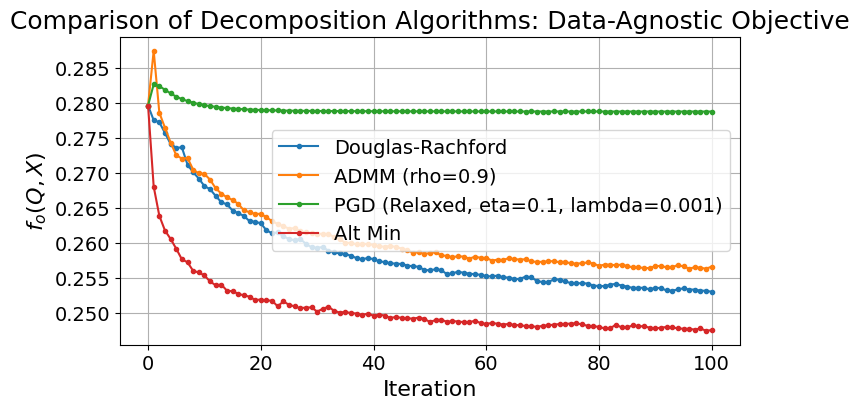

In [109]:
plt.figure(figsize=(8, 4))
plt.title("Comparison of Decomposition Algorithms: Data-Agnostic Objective", fontdict={'size': 18})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Iteration", fontdict={'size': 16})
plt.ylabel("$f_o(Q, X)$", fontdict={'size': 16})

for name, error_list in errors_3.items():
    plt.plot(error_list, '.-', label=name)
plt.legend(fontsize=14)
plt.grid(axis="both")
plt.savefig("dr_data_agnostic.png", bbox_inches='tight')

In [40]:
admm_rho = 0.8
pgd_eta = 1e-4
relaxed_pgd_eta = 1e-2
pgd_lambda = 1e-3

In [41]:
decomps = {
    "Douglas-Rachford": (DouglasRachford, {}),
    f"ADMM (rho={admm_rho})": (ADMM, {"rho": admm_rho}),
    f"PGD (Relaxed, eta={relaxed_pgd_eta}, lambda={pgd_lambda})": (PGDRelaxed, {"eta": relaxed_pgd_eta, "lmbda": pgd_lambda}),
    "Alt Min": (AlternatingMinimization, {})
}

In [42]:
errors_4 = {}
for name, (decomp_cls, kwargs) in decomps.items():
    decomp = decomp_cls(rank=128, data_aware=True, quant_Q=Q_quant, quant_LR=LR_quant)
    decomp.decompose(W, H, n_iter=100, n_iter_inner=5, **kwargs)
    errors_4[name] = decomp.errors

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


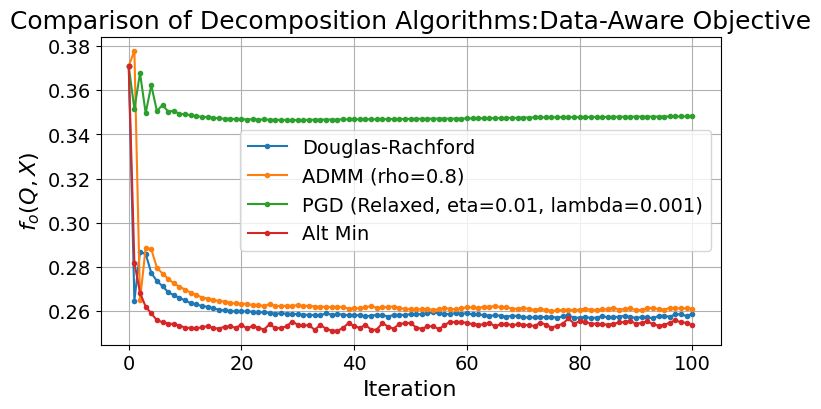

In [108]:
plt.figure(figsize=(8, 4))
plt.title("Comparison of Decomposition Algorithms:Data-Aware Objective", fontdict={'size': 18})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Iteration", fontdict={'size': 16})
plt.ylabel("$f_o(Q, X)$", fontdict={'size': 16})

for name, error_list in errors_4.items():
    plt.plot(error_list, '.-', label=name)
plt.legend(fontsize=14)
plt.grid(axis="both")
plt.savefig("dr_data_agnostic.png", bbox_inches='tight')

In [45]:
img = nib.load("data/sub-01_inplaneT2.nii.gz")

In [46]:
data = img.get_fdata()

In [47]:
W2 = torch.from_numpy(data[:, :, 20])

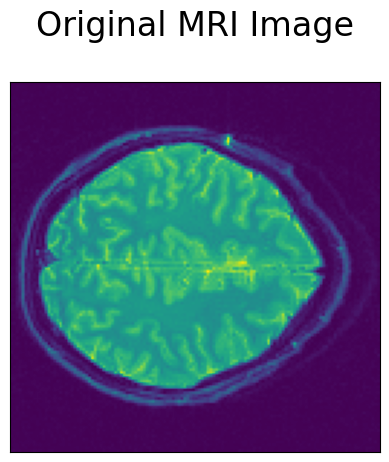

In [134]:
plt.imshow(W2)
plt.title("Original MRI Image\n", fontdict={"size": 24})

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

In [49]:
LR_quant = LatticeQuantizer(num_bits=4)

In [57]:
altmin = AlternatingMinimization(rank=16, data_aware=False, quant_Q=Q_quant, quant_LR=LR_quant)
W2_altmin = altmin.decompose(W2, None, n_iter=100, n_iter_inner=5, re_init_lplr=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 30.30it/s]


In [58]:
psnr = PeakSignalNoiseRatio()
psnr.update(W2_altmin, W2)
psnr.compute()

tensor(31.3253, dtype=torch.float64)

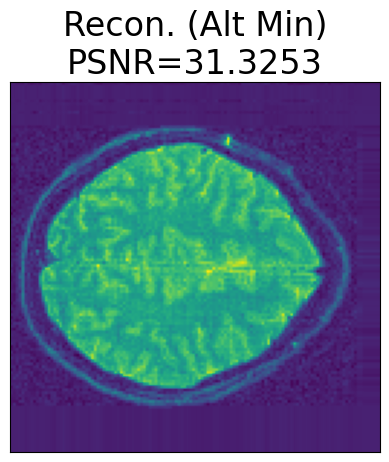

In [126]:
plt.title("Recon. (Alt Min)\nPSNR=31.3253", fontdict={"size": 24})
plt.imshow(W2_altmin)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

In [127]:
admm = ADMM(rank=16, data_aware=False, quant_Q=Q_quant, quant_LR=LR_quant)
W2_admm = admm.decompose(W2, None, n_iter=100, n_iter_inner=5, rho=0.5)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


In [128]:
psnr = PeakSignalNoiseRatio()
psnr.update(W2_admm, W2)
psnr.compute()

tensor(31.2274, dtype=torch.float64)

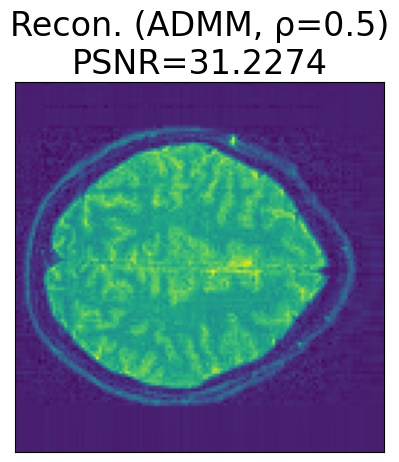

In [133]:
plt.imshow(W2_admm)
plt.title("Recon. (ADMM, ρ=0.5)\nPSNR=31.2274", fontdict={"size": 24})
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

In [63]:
dr = DouglasRachford(rank=16, data_aware=False, quant_Q=Q_quant, quant_LR=LR_quant)
W2_dr = dr.decompose(W2, None, n_iter=100, n_iter_inner=5)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


In [65]:
psnr = PeakSignalNoiseRatio()
psnr.update(W2_dr, W2)
psnr.compute()

tensor(29.1135, dtype=torch.float64)

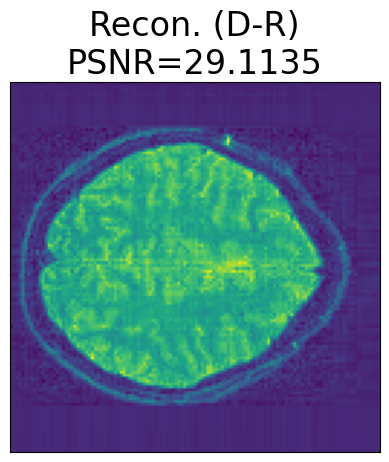

In [132]:
plt.imshow(W2_dr)
plt.title("Recon. (D-R)\nPSNR=29.1135", fontdict={"size": 24})
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

In [67]:
pgd = PGDRelaxed(rank=16, data_aware=False, quant_Q=Q_quant, quant_LR=LR_quant)
W2_pgd = pgd.decompose(W2, None, n_iter=100, eta=1e-5, lmbda=1e-4)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 46.48it/s]


In [68]:
psnr = PeakSignalNoiseRatio()
psnr.update(W2_pgd, W2)
psnr.compute()

tensor(28.3692, dtype=torch.float64)

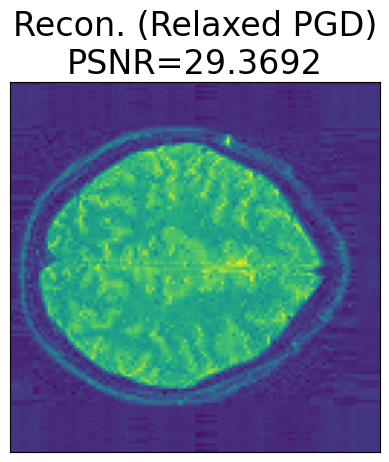

In [131]:
plt.imshow(W2_pgd)
plt.title("Recon. (Relaxed PGD)\nPSNR=29.3692", fontdict={"size": 24})
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


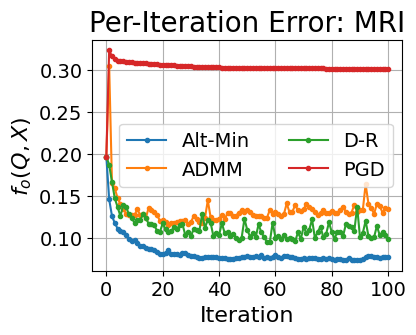

In [139]:
plt.figure(figsize=(4, 3))
plt.title("Per-Iteration Error: MRI", fontdict={'size': 20})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Iteration", fontdict={'size': 16})
plt.ylabel("$f_o(Q, X)$", fontdict={'size': 16})

plt.plot(altmin.errors, '.-', label="Alt-Min")
plt.plot(admm.errors, '.-', label="ADMM")
plt.plot(dr.errors, '.-', label="D-R")
plt.plot(pgd.errors, '.-', label="PGD")
plt.legend(fontsize=14, ncols=2)
plt.grid(axis="both")
plt.savefig("dr_data_agnostic.png", bbox_inches='tight')